In [90]:
from transformers import TFAutoModel,AutoTokenizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [91]:
df=pd.read_csv("merged_data.csv")

In [92]:
df["text"]

0         i have a feeling that i will find another idea...
1                        i feel no fake sympathy can soften
2             No. I have kids_comma_ but they are toddlers.
3         i feel awkward tagging celebs in tweets or on ...
4               i feel really lonely tonight support anyone
                                ...                        
125839                     Did you have a lot of work done?
125840    I was watching professional rodeo last night. ...
125841    That is an amazing talent to have. I would be ...
125842    Yeah they must practice a lot. I would be afra...
125843                Me too_comma_ that would be terrible.
Name: text, Length: 125844, dtype: object

In [93]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform labels
df["label"] = label_encoder.fit_transform(df["label"])

# Get label mappings
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Print the mapping
print("Label Encoding Mapping:")
for label, index in label_mapping.items():
    print(f"{label}: {index}")


Label Encoding Mapping:
anger: 0
annoyed: 1
anticipating: 2
confident: 3
disgusted: 4
embarrassed: 5
fear: 6
impressed: 7
jealous: 8
joy: 9
lonely: 10
love: 11
nostalgic: 12
sadness: 13
sentimental: 14
surprise: 15


In [94]:
emotions_len=len(df['label'].unique())
emotions_len


16

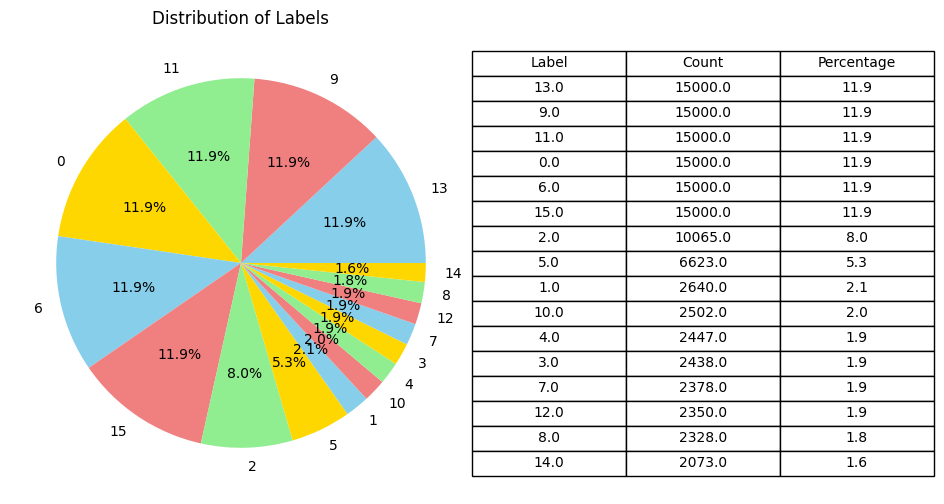

In [95]:
import matplotlib.pyplot as plt
import pandas as pd

# Count values
label_counts = df['label'].value_counts()
percentages = (label_counts / label_counts.sum()) * 100  # Convert to percentage

# Create a figure
fig, ax = plt.subplots(figsize=(10, 6))

# Pie chart
ax.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', colors=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
ax.set_title("Distribution of Labels")

# Create a table
table_data = {'Label': label_counts.index, 'Count': label_counts.values, 'Percentage': percentages.round(1)}
table_df = pd.DataFrame(table_data)

# Add table to plot
table = plt.table(cellText=table_df.values, colLabels=table_df.columns, cellLoc='center', loc='right')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)

# Show plot
plt.show()


In [96]:
import re
import string
#Preprocess text
def preprocess_text(text):
    text=text.lower()
    text=re.sub('[^a-z A-Z 0-9]','',text)
    text= text.translate(str.maketrans("", "", string.punctuation))  # Remove punctuation
    text= re.sub(r'\d+', '', text)  # Remove numbers
    return text.strip()

In [97]:
df['text']=df['text'].apply(lambda x: preprocess_text(x))


In [98]:
df["text"]

0         i have a feeling that i will find another idea...
1                        i feel no fake sympathy can soften
2                 no i have kidscomma but they are toddlers
3         i feel awkward tagging celebs in tweets or on ...
4               i feel really lonely tonight support anyone
                                ...                        
125839                      did you have a lot of work done
125840    i was watching professional rodeo last night i...
125841    that is an amazing talent to have i would be s...
125842    yeah they must practice a lot i would be afrai...
125843                   me toocomma that would be terrible
Name: text, Length: 125844, dtype: object

In [99]:
#load the RoBERTa tokenizer
tokenizer=AutoTokenizer.from_pretrained('roberta-base')

In [100]:
from sklearn.model_selection import train_test_split
train_texts,test_texts=train_test_split(df,test_size=0.2,random_state=42)

In [101]:
def tokenize_text(texts, max_length=128):
    return tokenizer(texts["text"], padding="max_length", truncation=True, max_length=max_length)

In [102]:
from datasets import Dataset, DatasetDict
train_dataset = Dataset.from_pandas(train_texts)
test_dataset = Dataset.from_pandas(test_texts)

# Create DatasetDict
emotions = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

In [103]:
emotions

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'text', 'label', '__index_level_0__'],
        num_rows: 100675
    })
    test: Dataset({
        features: ['Unnamed: 0', 'text', 'label', '__index_level_0__'],
        num_rows: 25169
    })
})

In [104]:
emotions_encoded = emotions.map(tokenize_text, batched=True, batch_size=128)

Map: 100%|██████████| 25169/25169 [00:02<00:00, 9933.65 examples/s] 


In [105]:
train_features={
    "input_ids":emotions_encoded["train"]["input_ids"],
    "attention_mask":emotions_encoded["train"]["attention_mask"]
}
train_labels=tf.keras.utils.to_categorical(emotions_encoded["train"]["label"])

In [106]:
test_features={
    "input_ids":emotions_encoded["test"]["input_ids"],
    "attention_mask":emotions_encoded["test"]["attention_mask"]
}
test_labels=tf.keras.utils.to_categorical(emotions_encoded["test"]["label"])

In [107]:
emotions_encoded.set_format('tf', columns=['input_ids', 'attention_mask', 'label'])

In [108]:
emotions_encoded

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'text', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 100675
    })
    test: Dataset({
        features: ['Unnamed: 0', 'text', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 25169
    })
})

In [109]:
# Convert datasets to tf.data format
BATCH_SIZE = 128

def order(inputs, labels):
    return {
        "input_ids": tf.convert_to_tensor(inputs["input_ids"], dtype=tf.int32),
        "attention_mask": tf.convert_to_tensor(inputs["attention_mask"], dtype=tf.int32),
    }, tf.convert_to_tensor(labels, dtype=tf.float32)

In [110]:
train_dataset=tf.data.Dataset.from_tensor_slices((train_features,train_labels))
train_dataset=train_dataset.shuffle(1000).batch(batch_size=BATCH_SIZE)
train_dataset=train_dataset.map(order,num_parallel_calls=tf.data.AUTOTUNE)


In [111]:
train_dataset

<_ParallelMapDataset element_spec=({'input_ids': TensorSpec(shape=(None, 128), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(None, 128), dtype=tf.int32, name=None)}, TensorSpec(shape=(None, 16), dtype=tf.float32, name=None))>

In [112]:
# # ... doing the same for test set ...
test_dataset = tf.data.Dataset.from_tensor_slices((test_features, test_labels))
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.map(order, num_parallel_calls=tf.data.AUTOTUNE)

In [113]:
inp, out = next(iter(train_dataset)) # a batch from train_dataset
print(inp, '\n\n', out)


{'input_ids': <tf.Tensor: shape=(128, 128), dtype=int32, numpy=
array([[   0,  118,  216, ...,    1,    1,    1],
       [   0,  118,  619, ...,    1,    1,    1],
       [   0,  118,  619, ...,    1,    1,    1],
       ...,
       [   0, 6025,   16, ...,    1,    1,    1],
       [   0,  118, 1166, ...,    1,    1,    1],
       [   0,  118,  619, ...,    1,    1,    1]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(128, 128), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>} 

 tf.Tensor(
[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(128, 16), dtype=float32)


In [114]:
model=TFAutoModel.from_pretrained('roberta-base')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias', 'roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [115]:
class RoBERTaEmbedding(tf.keras.Model):
    def __init__(self, model):
        super(RoBERTaEmbedding, self).__init__()
        self.model = model

    def call(self, inputs):
        input_ids = inputs["input_ids"]
        attention_mask = inputs["attention_mask"]
        roberta_output = self.model(input_ids=input_ids, attention_mask=attention_mask, training=False)
        return roberta_output.last_hidden_state  # (batch_size, seq_len, hidden_size)


class RoBERTa_LSTM(tf.keras.Model):
    def __init__(self, roberta_model, lstm_units=128, num_classes=emotions_len):
        super(RoBERTa_LSTM, self).__init__()
        self.roberta = roberta_model  # Pretrained RoBERTa
        self.lstm = tf.keras.layers.LSTM(lstm_units, return_sequences=False)
        self.dense = tf.keras.layers.Dense(num_classes, activation="softmax")  # Classification layer

    def call(self, inputs):
        roberta_embeddings = self.roberta(inputs)  # (batch_size, seq_len, hidden_size)
        lstm_output = self.lstm(roberta_embeddings)  # (batch_size, lstm_units)
        output = self.dense(lstm_output)  # (batch_size, num_classes)
        return output



In [120]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
roberta_embedding=RoBERTaEmbedding(model)
roberta_embedding.compile(optimizer=opt,
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"])
# Create model instance
roberta_lstm_model = RoBERTa_LSTM(roberta_embedding)
roberta_lstm_model.compile(
    optimizer=opt,
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)


In [121]:
roberta_lstm_model.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

In [ ]:
history = roberta_lstm_model.fit(
    train_dataset,
    epochs=3,batch_size=4
    
)

Epoch 1/3


  4/787 [..............................] - ETA: 5:50:29 - loss: 2.6711 - accuracy: 0.0801